In [7]:
import glob
import os.path

from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

from sklearn import ensemble, neural_network
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Predict power load using temperature

In [2]:
# Use this for larger plots:
#matplotlib.rc('figure', figsize=(15, 10))
matplotlib.rc('figure', figsize=(10, 8))

In [3]:
COUNTRIES = 'Austria', 'Germany', 'Switzerland', 'Italy', 'Spain', 'Sweden', 'United Kingdom'

In [4]:
CONFIG_FILE = '../entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [5]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    
    print("Files read, concatenating to dataframe...")
    data = pd.concat(each_csv_file, ignore_index=True)
    
    print("Sorting and indexing...")
    data = data.set_index("DateTime")
    data.sort_index(inplace=True)
    
    # filter only for countries under consideration to make things faster and consume less RAM...
    data_ = data[data.AreaName.isin(COUNTRIES)].copy()
    del data
    data = data_
    
    print("Resampling...")
    data = data.groupby('AreaName').resample("1h").mean()
    
    # we should end up with a dataframe with DateTime as index, AreaName as columns
    # and Total load as entries...
    print("Reshaping dataframe...")
    data = data.TotalLoadValue.unstack(level=0).interpolate()
    
    print("Loading done.")

    return data


# note: this might require 3GB of RAM

power_demand = load_complete_entso_e_data(download_dir)

Concatenating 69 csv files...
Files read, concatenating to dataframe...
Sorting and indexing...
Resampling...
Reshaping dataframe...
Loading done.


In [53]:
power_train = power_demand.Austria['2016-01-01':'2018-12-31']
power_test  = power_demand.Austria['2019-01-01':'2019-12-31']

### Random forests with features dayofyear/hour/weekday

In [54]:
def get_fetures(data):
    dayofyear = data.index.dayofyear.values[:, np.newaxis]
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((dayofyear, hour, weekday), axis=1)

In [55]:
X_train = get_fetures(power_train)
X_test = get_fetures(power_test)
Y_train = power_train.values
Y_test = power_test.values

In [56]:
forest = ensemble.RandomForestRegressor()
forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [57]:
forest.score(X_test, Y_test)

0.8931721824234694

### Can we improve residuals with using temperature?

In [58]:
temperature = xr.load_dataset("../data/temperatures_era5.nc").t2m.sel(longitude=16.5, latitude=48)

In [59]:
def mean_temperature_dayofyear(temperature, time):
    temperature_interpolated = temperature.interp(time=time)
    return temperature_interpolated.groupby(temperature_interpolated.time.dt.dayofyear).mean()

In [60]:
temperature_train = mean_temperature_dayofyear(temperature=temperature, time=power_training.index)
temperature_test = mean_temperature_dayofyear(temperature=temperature, time=power_test.index)

In [61]:
residuals = pd.Series(Y_test - forest.predict(X_test), index=power_test.index)

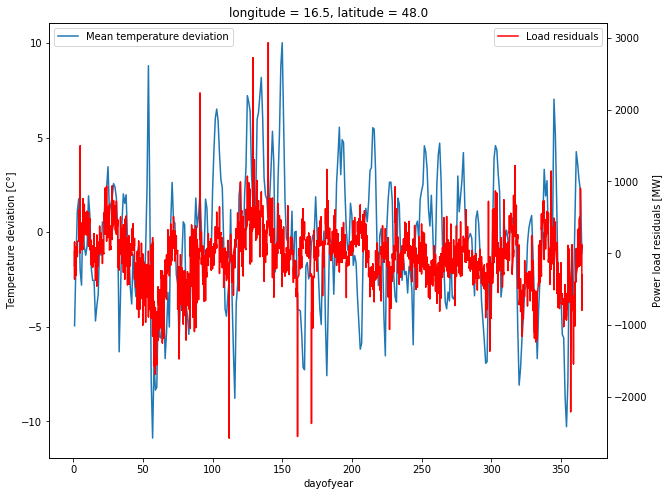

In [62]:
(temperature_train - temperature_test).plot.line(label='Mean temperature deviation')
plt.legend(loc='upper left')
plt.ylabel('Temperature deviation [C°]')
ax2 = plt.gca().twinx()
ax2.plot(power_test.index.dayofyear, residuals, 'r-', label='Load residuals')
plt.ylabel('Power load residuals [MW]')
plt.legend()

Text(0.5, 0, 'Temperature deviation [C°]')

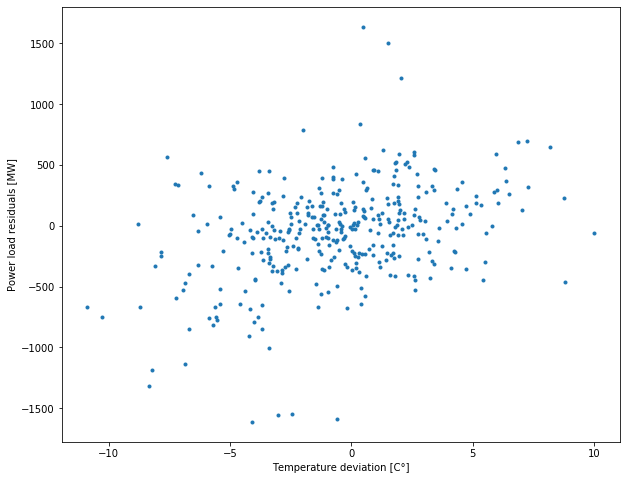

In [63]:
plt.plot(temperature_train - temperature_test,
         residuals.groupby(residuals.index.dayofyear).mean(), 'o', markersize=3)
plt.ylabel('Power load residuals [MW]')
plt.xlabel('Temperature deviation [C°]')

Okay, not sure if there is a lot of dependence here. Let's try it out!

In [92]:
def get_fetures(data, temperature):
    dayofyear = data.index.dayofyear.values[:, np.newaxis]
    week = data.index.week.values[:, np.newaxis]
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((dayofyear, week, hour, weekday, temperature.values[:, np.newaxis]), axis=1)

In [93]:
X_train = get_fetures(power_train, temperature.interp(time=power_train.index))
X_test = get_fetures(power_test, temperature.interp(time=power_test.index))
Y_train = power_train.values
Y_test = power_test.values

In [94]:
forest = ensemble.RandomForestRegressor()
forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [95]:
forest.score(X_test, Y_test)

0.9345877221132488

### Random forests with features week of year/hour/weekday

In [96]:
def get_fetures(data):
    week = data.index.week.values[:, np.newaxis]
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((week, hour, weekday), axis=1)

In [97]:
X_train = get_fetures(power_train)
X_test = get_fetures(power_test)
Y_train = power_train.values
Y_test = power_test.values

In [98]:
forest = ensemble.RandomForestRegressor()
forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [99]:
forest.score(X_test, Y_test)

0.8995341051227149

### Linear regression with dummies with features dayofyear/hour/weekday

In [104]:
def get_dummies(data):
    dayofyear = pd.get_dummies(pd.Categorical(data.index.dayofyear, categories=np.arange(1,367)))
    hour = pd.get_dummies(data.index.hour)
    weekday = pd.get_dummies(data.index.weekday)
    return np.concatenate((dayofyear, hour, weekday), axis=1)

In [105]:
X_train = get_dummies(power_train)
X_test = get_dummies(power_test)
Y_train = power_train.values
Y_test = power_test.values

In [106]:
forest = LinearRegression()
forest.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [107]:
forest.score(X_test, Y_test)

0.8580713500177406

### Linear regression with dummies with features month/hour/weekday

In [108]:
def get_dummies(data):
    month = pd.get_dummies(data.index.month)
    hour = pd.get_dummies(data.index.hour)
    weekday = pd.get_dummies(data.index.weekday)
    return np.concatenate((month, hour, weekday), axis=1)

In [109]:
X_train = get_dummies(power_train)
X_test = get_dummies(power_test)
Y_train = power_train.values
Y_test = power_test.values

In [110]:
forest = LinearRegression()
forest.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [111]:
forest.score(X_test, Y_test)

0.8253180803001711

### Random forests with features month/hour/weekday

In [112]:
def get_fetures(data):
    month = data.index.month.values[:, np.newaxis]
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((month, hour, weekday), axis=1)

In [113]:
X_train = get_fetures(power_training)
X_test = get_fetures(power_test)
Y_train = power_training.values
Y_test = power_test.values

In [114]:
forest = ensemble.RandomForestRegressor()
forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [115]:
forest.score(X_test, Y_test)

0.8780951045930208

### Can we increase R2 score by reducing size feature space?

Let's do something in between week of year and day of year, by putting consecutive days into bins of a certain size. `binsize=1` would be equivalent to dayofyear and 7 would be very similar to week of year (except first and last week of the year).

In [116]:
def get_fetures(data, binsize=1):
    bin_ = data.index.dayofyear.values[:, np.newaxis]
    bin_ = np.floor(bin_ / binsize).astype(np.int)
    
    hour = data.index.hour.values[:, np.newaxis]
    weekday = data.index.weekday.values[:, np.newaxis]
    return np.concatenate((bin_, hour, weekday), axis=1)

In [117]:
scores = []

for binsize in np.arange(1, 150):
    X_train = get_fetures(power_training, binsize=binsize)
    X_test = get_fetures(power_test, binsize=binsize)
    Y_train = power_training.values
    Y_test = power_test.values

    forest = ensemble.RandomForestRegressor()
    forest.fit(X_train, Y_train)

    scores.append(forest.score(X_test, Y_test))
    print("binsize = ", binsize, "R2 test score = ", scores[-1])

1 0.8938585672149643
2 0.8827850406102421
3 0.8960074853355353
4 0.8758577094636553
5 0.8773677992397767
6 0.8865107280903246
7 0.9006798535995849
8 0.8896045848799539
9 0.8959001720695959
10 0.8893150859882724
11 0.9006708772846955
12 0.8866319164080441
13 0.899022431764373
14 0.8964931824218723
15 0.8929483890083583
16 0.8997019069850445
17 0.9043624007457831
18 0.8912058479920943
19 0.8859715372912139
20 0.8850844554008048
21 0.9058347268813224
22 0.9036787644064094
23 0.888067561947015
24 0.8855625809533022
25 0.8920234591700857
26 0.8893276736513414
27 0.8980301469195774
28 0.8865924984810903
29 0.8927235628162242
30 0.8865325934103234
31 0.882264250735675
32 0.8892135129920314
33 0.8836242558639054
34 0.8797509822011946
35 0.8930231082480843
36 0.8810916282375255
37 0.874928620765455
38 0.8794609988281918
39 0.8944541651980017
40 0.8778526448101804
41 0.8707492247656812
42 0.8708609787410302
43 0.883244552850012
44 0.9011842654914817
45 0.8928207735730318
46 0.882972448477997
47 

KeyboardInterrupt: 

Text(0.5, 0, 'Number of days aggregated as feature (binsize)')

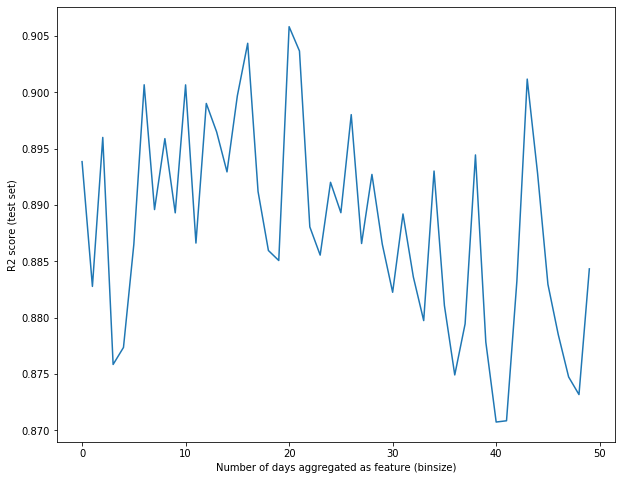

In [122]:
plt.plot(scores[:50])
plt.ylabel('R2 score (test set)')
plt.xlabel('Number of days aggregated as feature (binsize)')